In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
import os #for dealing with directries
import numpy as np #numarical python
import matplotlib.pyplot as plt # for ploatong
import tensorflow as tf #To use diffrent type of Tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet# MObike embaded application
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout# Minly need for classification task
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix#For evaluation cases

In [3]:
#Setting the path
dataset_path = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'
#List all the classes and types
classes = os.listdir(dataset_path)
num_classes = len(classes)
print(num_classes)
print(classes)

90
['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']


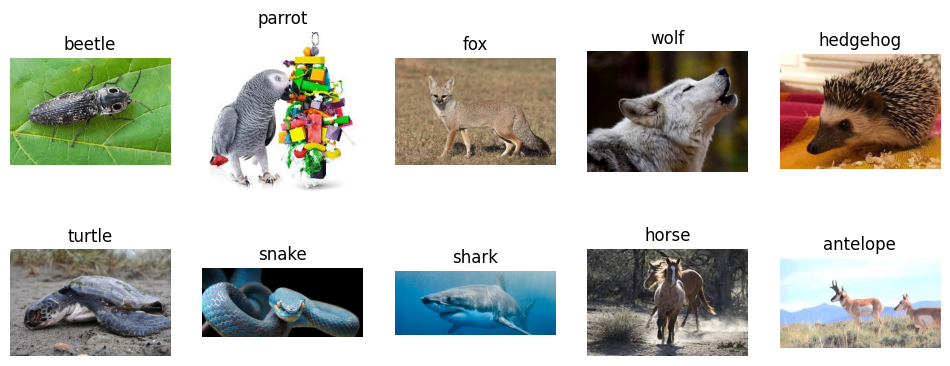

In [4]:
#Now start some visualization like oictures {Some samoke images}
plt.figure(figsize=(12, 12)) # Size of the canvas
for i, class_name in enumerate(classes[ :10]):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]#0 stand for to show very first eliement
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(5, 5, i+1)# i+1 is used because the image shown one after other
  plt.imshow(img)
  plt.title(class_name)
  plt.axis('off')#To turn off Grid view
plt.show()


In [5]:
#Preprocessing Stage
#Define  image size and batch size

img_size = (224, 224) #For MObileNetV2
batch_size = 64

#Data augumentation and Preproscessing
datagen = ImageDataGenerator(
    rescale=1./255,#We need to set rescale to understand for computer help to computer for understand the pixel of the image
    validation_split=0.1
)

#Crate training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [6]:
#Map the class - class_indices

class_indices = train_generator.class_indices
print(class_indices)

#extract class names
class_names = list(class_indices.keys())
print("cLASS NAMES", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [9]:
# load MobileNetV2 as the base model
from tensorflow.keras.applications import MobileNetV2 # Add this line
base_model = MobileNetV2(
    weights = 'imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model weights, training
base_model.trainable =False

# Add custom layers on top of the base model GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation= 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)#outputlayer

# Create the final model
model = Model(inputs=base_model.input,outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy', # Corrected typo here
              metrics = ['accuracy'])

# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy', # Corrected the loss function name
              metrics = ['accuracy'])
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples  // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples  // batch_size,
    epochs = 20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 899ms/step - accuracy: 0.3310 - loss: 3.1214 - val_accuracy: 0.7988 - val_loss: 0.7685
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6562 - loss: 1.2450

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6562 - loss: 1.2450 - val_accuracy: 0.8027 - val_loss: 0.7615
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 533ms/step - accuracy: 0.8352 - loss: 0.5873 - val_accuracy: 0.8164 - val_loss: 0.6260
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9167 - loss: 0.2577 - val_accuracy: 0.8125 - val_loss: 0.6360
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 74s 490ms/step - accuracy: 0.8990 - loss: 0.3517 - val_accuracy: 0.8457 - val_loss: 0.5490
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8906 - loss: 0.3624 - val_accuracy: 0.8379 - val_loss: 0.5662
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 564ms/step - accuracy: 0.9235 - loss: 0.2630 - val_accuracy: 0.8418 - val_loss: 0.5930
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9062 - loss: 0.3007 - val_accuracy: 0.8359 - val_loss: 0.5812
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 509ms/step - accuracy: 0.9559 - loss: 0.1608 - val_accuracy: 0.8574 - val_

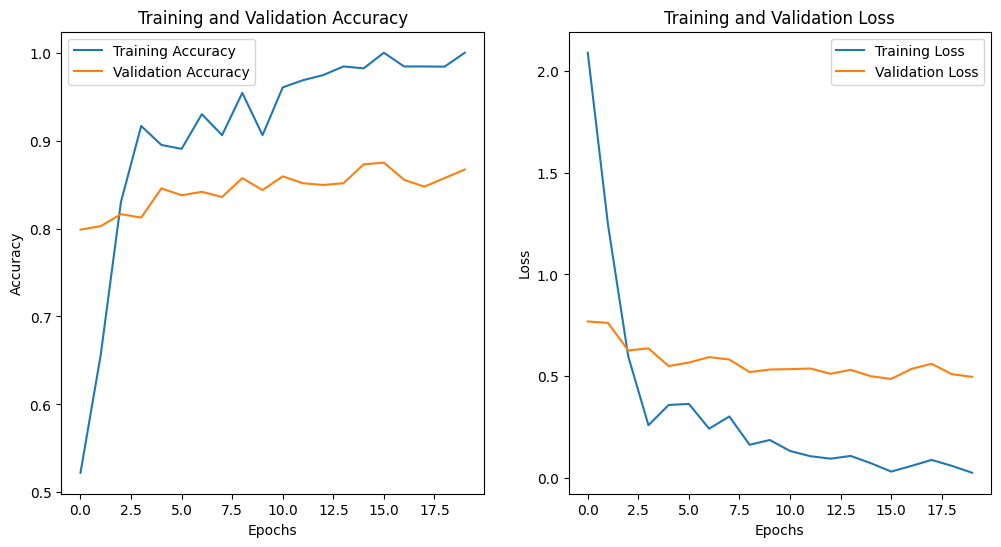

In [11]:
# Evaluate the model - plotting the training and validation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [12]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 800ms/step - accuracy: 0.8764 - loss: 0.4761
Validation Loss: 0.5108318328857422
Validation Accuracy: 0.864814817905426


In [14]:
# Save the model
model.save('Animal.keras')

In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

loaded_model = load_model('MCAR.keras')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction)

    plt.imshow(img)
    plt.title(f"Predicted Class: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()

In [17]:
os.listdir("/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/fox")

['4f98c92165.jpg',
 '4b3e1ebb6b.jpg',
 '32a391f189.jpg',
 '19f72b1098.jpg',
 '2b0f4e95c9.jpg',
 '2d70da21cb.jpg',
 '6f8cc50153.jpg',
 '1befbe965f.jpg',
 '1b2b288aa8.jpg',
 '9b10553454.jpg',
 '27c9fd5a6c.jpg',
 '3c1377bd9b.jpg',
 '5ec40607cb.jpg',
 '0ae0157e0c.jpg',
 '05d5c1e68f.jpg',
 '5a09f80a3a.jpg',
 '6d93c39746.jpg',
 '1a89f88226.jpg',
 '21e8d36a33.jpg',
 '6d049ab135.jpg',
 '41b324a161.jpg',
 '6e4f9bb366.jpg',
 '58e1d5a93e.jpg',
 '051c0550cd.jpg',
 '9b77a2be24.jpg',
 '4e8b178728.jpg',
 '6faa13ca45.jpg',
 '3ad5e120fa.jpg',
 '44b5622450.jpg',
 '2f92d49526.jpg',
 '6b0dc9ab1a.jpg',
 '0a9a650a0b.jpg',
 '2c515129f5.jpg',
 '7ef7525e84.jpg',
 '3d89f3103a.jpg',
 '6f6b829eef.jpg',
 '5f6e0bdad2.jpg',
 '69c5b5725e.jpg',
 '70ca2955fc.jpg',
 '68fa2cb7e0.jpg',
 '57a01ef79d.jpg',
 '046e05e07b.jpg',
 '2eff70f4f6.jpg',
 '9dff4eb761.jpg',
 '49dad2f338.jpg',
 '0cfb16f2dd.jpg',
 '7ff48267ad.jpg',
 '05f072dffb.jpg',
 '9e8313914a.jpg',
 '53b4c26601.jpg',
 '6f36425496.jpg',
 '41b2d066a8.jpg',
 '27eaa1ccdd

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


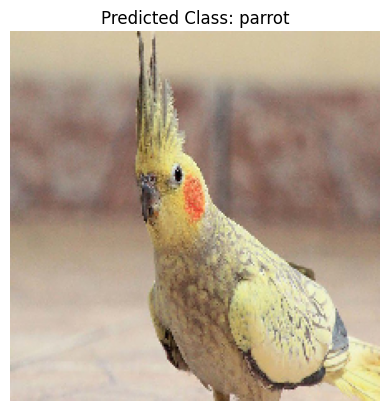

In [18]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot/9c2dd51734.jpg')